# Training Notebook

##### Import Packages and Set Up

In [384]:
import pandas as pd

import argparse
import json
import logging
import os
import itertools

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed

from typing import List

import matplotlib.pyplot as plt

## Set up logger to get details of errors
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

## Set up device settings
device = "cuda" if torch.cuda.is_available() else "cpu"

##### Import Data

The imported data is a list of elliptic curves of rank 1.  Each curve is represented in binary.

In [385]:
coef_df_binary = pd.read_csv("https://raw.githubusercontent.com/jcox22/Sagemaker_practice_gan/main/rank_1_curves.csv")
coef_df_binary = coef_df_binary.drop(columns = ['Unnamed: 0'])

One of the key values we use in the training of our model is the variance of the original dataset.  The idea is that we can try to mimick the natural variance in that dataset to create heterogeneity in the curves we generate.

In [386]:
# Create Variance variables from data
variances = coef_df_binary.describe().loc[['std']]**2
real_var = torch.tensor(variances.to_numpy(), dtype = torch.float32, device = device)

##### Set Parameters

The following are all key parameters of the GAN model we are training.  We also create names for the specific model we are training by the values of these parameters.  That way when we are looking back at the long list of models we test, it is easy to identify how each model is trained.

In [471]:
# k is for number of nodes in each hidden layer of NN
k = 900

# For number of inputs (32 binary digits)
input_length = 32
output_length = input_length

# Model Parameters
epochs = 10
batch_size = 256
lr = 0.001
momentum = 0.9
var_weight = 1.0
layers = 4

# Needed later on for save_model
model_dir = '/models'
data_dir = '/training'
model_name = 'noisy' + str(layers) + 'layers_' + str(epochs) + 'epochs_' + str(k) + 'nodes_' + str(batch_size) + 'batch_size_' + str(lr) + 'lr_' + str(var_weight) + 'var_weight'
loss_folder = './Losses/' + model_name

##### Create New Folders to Save Loss Info

One of the statistics that we want to track is loss information over each epoch.  To simplify the process over training many models, we can save each models loss infomation in its own folder.  These folders are found under the 'Losses' folder.

In [472]:
try:
    os.mkdir(loss_folder)
except OSError:
    print ("Creation of the directory %s failed" % loss_folder)
else:
    print ("Successfully created the directory %s " % loss_folder)

Successfully created the directory ./Losses/noisy4layers_10epochs_900nodes_256batch_size_0.001lr_1.0var_weight 


##### Training Dataset

The following cell sets up the training data that we previously loaded into the format that Pytorch prefers for its training jobs.  

In [473]:
train_tensor = torch.tensor(coef_df_binary.to_numpy(), dtype = torch.float32, device = device)
train_ds = torch.utils.data.TensorDataset(train_tensor)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last = True)

##### Set Distribution of initial inputs

In [474]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal(m.weight)

##### Create NN Classes

In [475]:
if layers == 3:
    class Generator(nn.Module):
        def __init__(self, output_length: int):
            super(Generator, self).__init__()
            self.dense_layer = nn.Linear(output_length, k)
            self.dense_layer2 = nn.Linear(k, k)
            self.dense_layer3 = nn.Linear(k, output_length)

        def forward(self, x):
            l1 = self.dense_layer(x)
            l2 = self.dense_layer2(F.relu(l1))
            l3 = self.dense_layer3(F.relu(l2))
            return l3
    
    class Discriminator(nn.Module):
        def __init__(self, input_length: int):
            super(Discriminator, self).__init__()
            self.dense_layer = nn.Linear(int(input_length), k)
            self.dense_layer2 = nn.Linear(k, k)
            self.dense_layer3 = nn.Linear(k, 1)

        def forward(self, x):
            l1 = self.dense_layer(x)
            l2 = self.dense_layer2(F.relu(l1))
            l3 = self.dense_layer3(F.relu(l2))
            return l3
        
elif layers == 4:
    class Generator(nn.Module):
        def __init__(self, output_length: int):
            super(Generator, self).__init__()
            self.dense_layer = nn.Linear(output_length, k)
            self.dense_layer2 = nn.Linear(k, k)
            self.dense_layer3 = nn.Linear(k, k)
            self.dense_layer4 = nn.Linear(k, output_length)

        def forward(self, x):
            l1 = self.dense_layer(x)
            l2 = self.dense_layer2(F.relu(l1))
            l3 = self.dense_layer3(F.relu(l2))
            l4 = self.dense_layer4(F.relu(l3))
            return l4
    
    class Discriminator(nn.Module):
        def __init__(self, input_length: int):
            super(Discriminator, self).__init__()
            self.dense_layer = nn.Linear(int(input_length), k)
            self.dense_layer2 = nn.Linear(k, k)
            self.dense_layer3 = nn.Linear(k, k)
            self.dense_layer4 = nn.Linear(k, 1)

        def forward(self, x):
            l1 = self.dense_layer(x)
            l2 = self.dense_layer2(F.relu(l1))
            l3 = self.dense_layer3(F.relu(l2))
            l4 = self.dense_layer4(F.relu(l3))
            return l4
        
elif layers == 5:
        class Generator(nn.Module):
            def __init__(self, output_length: int):
                super(Generator, self).__init__()
                self.dense_layer = nn.Linear(output_length, k)
                self.dense_layer2 = nn.Linear(k, k)
                self.dense_layer3 = nn.Linear(k, k)
                self.dense_layer4 = nn.Linear(k, k)
                self.dense_layer5 = nn.Linear(k, output_length)

            def forward(self, x):
                l1 = self.dense_layer(x)
                l2 = self.dense_layer2(F.relu(l1))
                l3 = self.dense_layer3(F.relu(l2))
                l4 = self.dense_layer4(F.relu(l3))
                l5 = self.dense_layer5(F.relu(l4))
                return l5
    
        class Discriminator(nn.Module):
            def __init__(self, input_length: int):
                super(Discriminator, self).__init__()
                self.dense_layer = nn.Linear(int(input_length), k)
                self.dense_layer2 = nn.Linear(k, k)
                self.dense_layer3 = nn.Linear(k, k)
                self.dense_layer4 = nn.Linear(k, k)
                self.dense_layer5 = nn.Linear(k, 1)

            def forward(self, x):
                l1 = self.dense_layer(x)
                l2 = self.dense_layer2(F.relu(l1))
                l3 = self.dense_layer3(F.relu(l2))
                l4 = self.dense_layer4(F.relu(l3))
                l5 = self.dense_layer5(F.relu(l4))
                return l5

##### Set up for training function

In [476]:
logger.info("Device Type: {}".format(device))

# Call generator and discriminator
generator = Generator(output_length)
discriminator = Discriminator(input_length)

# Make sure it is on device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Apply distrubution type * 
generator.apply(init_normal)
discriminator.apply(init_normal)

# Loss
loss = nn.BCEWithLogitsLoss().to(device)
MSE = torch.nn.MSELoss(reduction = 'sum').to(device)

# Choose optimizer
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=momentum)

dis_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

/tmp/ipykernel_3464696/3949670600.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight)


In [477]:
def extract(G_of_noise):

    G_numpy = G_of_noise.detach()   

    curves = []

    for i in range(len(G_numpy)):
        c1 = int(G_numpy[i][0].round())
        c2 = ((-1)**(int(G_numpy[i][1].round())))*(int(G_numpy[i][2].round()))
        c3 = int(G_numpy[i][3].round())
        c4 = (-1)**(int(G_numpy[i][4].round()))*(int("".join([str(int(y)) for y in G_numpy[i][5:18].round()]), 2))
        c6 = (-1)**(int(G_numpy[i][12].round()))*(int("".join([str(int(y)) for y in G_numpy[i][19:].round()]), 2))
    
        coef = [c1,c2,c3,c4,c6]
        curves.append(coef)
    return curves


##### Training Loop

1
256
2
254
3
253
4
255
5
255
6
254
7
254
8
252
9
252
10
250
CPU times: user 27.6 s, sys: 10.5 s, total: 38.1 s
Wall time: 25 s


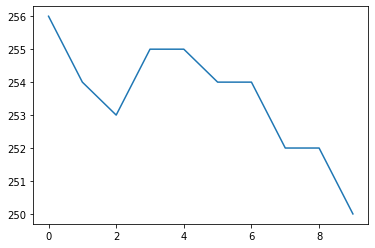

In [481]:
%%time
running_loss_list = []
average_td_gd_loss_list = []
running_loss_true_d_list = []
g_d_running_loss_list = []
number_curves = []

epoch_number = 1

for epoch in range(0, epochs):
    running_loss = 0.0
    average_td_gd_loss = 0.0
    running_loss_true_d = 0.0
    g_d_running_loss = 0.0
    
    for batch in enumerate(train_loader):
        # Create a noisy input
        noise = torch.randint(0, 2, size=(batch_size, output_length)).float()
        noise = noise.to(device)
    
        # Generate Labels of data
        true_labels = [1] * batch_size
        true_labels = torch.tensor(true_labels).float()
        true_labels = true_labels.to(device).resize_((batch_size, 1))
        
        false_labels = torch.zeros(batch_size).to(device).resize_((batch_size, 1))
        
        # Generate Labels of data with noise
        true_labels_noisy = [1 - 0.1 * torch.rand(1)] * batch_size
        true_labels_noisy = torch.tensor(true_labels_noisy).float()
        true_labels_noisy = true_labels_noisy.to(device).resize_((batch_size, 1))
        
        false_labels_noisy = [0 + 0.1*torch.rand(1)] * batch_size
        false_labels_noisy = torch.tensor(false_labels_noisy).float()
        false_labels_noisy = false_labels_noisy.to(device).resize_((batch_size, 1))
        
        
        # Take real data
        true_data = batch[1][0]

        # zero the parameter gradients
        gen_optimizer.zero_grad()

        # Forward Pass
        G_of_noise = generator(noise)
        D_of_G_of_noise = discriminator(torch.sigmoid(G_of_noise).round())
        
        # Calculate Loss
        generator_loss = loss(D_of_G_of_noise, true_labels) + MSE(real_var.squeeze(), torch.var(torch.sigmoid(G_of_noise), dim = 0))*(var_weight)
        generator_loss.backward()
        gen_optimizer.step()
            
        # Train the discriminator on the true/generated data
        dis_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels_noisy)

        # add .detach() here think about this
        generator_discriminator_out = discriminator(torch.sigmoid(G_of_noise.detach()).round()) # introduce new d_of_g_of_noise without gradient
        generator_discriminator_loss = loss(generator_discriminator_out, false_labels_noisy)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        dis_optimizer.step()

        # print statistics
        running_loss += generator_loss.item() * len(batch)
        average_td_gd_loss += discriminator_loss.item() * len(batch)
        running_loss_true_d += true_discriminator_loss.item() * len(batch)
        g_d_running_loss += generator_discriminator_loss.item() * len(batch)

        
    running_loss_list.append(running_loss / len(train_loader.dataset))
    average_td_gd_loss_list.append(average_td_gd_loss / len(train_loader.dataset))
    running_loss_true_d_list.append(running_loss_true_d / len(train_loader.dataset))
    g_d_running_loss_list.append(g_d_running_loss / len(train_loader.dataset))

    print(epoch_number)
    epoch_number += 1
    #var_weight += 0.05
    noise = torch.randint(0, 2, size=(batch_size, output_length)).float()
    noise = noise.to(device)
    listcurves = extract(torch.sigmoid(generator(noise)))
    listcurves.sort()
    unique_curves = list(listcurves for listcurves,_ in itertools.groupby(listcurves))
    print(len(unique_curves))
    number_curves.append(len(unique_curves))
   
## Save Losses
with open(loss_folder + '/running_loss.txt', "w") as output:
    output.write(str(running_loss_list))
    
with open(loss_folder + '/average_td_gd_loss.txt', "w") as output:
    output.write(str(average_td_gd_loss_list))
    
with open(loss_folder + '/running_loss_true_d.txt', "w") as output:
    output.write(str(running_loss_true_d_list))
    
with open(loss_folder + '/g_d_running_loss.txt', "w") as output:
    output.write(str(g_d_running_loss_list))
    
with open(loss_folder + '/unique_curves.txt', "w") as output:
    output.write(str(number_curves))
    
#plt.plot(running_loss_list, label = "Generator Loss")
#plt.plot(average_td_gd_loss_list, label = "Discriminator Loss")

plt.plot(number_curves, label = "Number of Unique Curves")


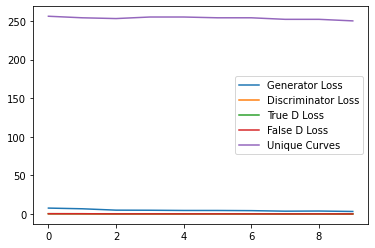

In [482]:
plt.plot(running_loss_list, label = "Generator Loss")
plt.plot(average_td_gd_loss_list, label = "Discriminator Loss")
plt.plot(running_loss_true_d_list, label = "True D Loss")
plt.plot(g_d_running_loss_list, label = "False D Loss")
plt.plot(number_curves, label = "Unique Curves")
plt.legend()
#plt.savefig('./Plots/mode_collapse.png')



In [456]:
##### Saving the Model

## The trained model will now be available in the 'Trained_Models' folder.

model_path = './Trained_Models/generator_' + model_name + '.pt' 

torch.save({
        'generator_state_dict': generator.state_dict(),
        'optimizer_state_dict': gen_optimizer.state_dict()
    }, model_path)

##### Now we have a saved model in the Trained_Models folder

Head over to the 'Model_Evaluation' notebook to see what kinds of curves this model generates!